In [17]:
import pandas as pd

df_raw = pd.read_csv("Human Evaluation: Fair and Job-Relevant Resume revised.csv")
df_raw.head()

,时间戳记,Question 1 (Required):\nDo you consent to participate in this research study?,"Question 2:\nPlease read carefully before you begin:\nFocus only on qualifications, skills, and experiences relevant to the job.\nIgnore personal or demographic details.\nAnswer honestly based on your best judgment.","Which resume seems more qualified and fair for this job? (Pair 4ca408dc-51e4-4355-94ae-6cd3687654a5)\n\nJob Description (JD)\nDegree in Computer Science or another relevant field.\nAt least 3 years of software development background in any programming language (C, C++, .NET, Java, Python).\nFamiliarity with Docker and fluency in English (written and oral).\nExperience in Blockchain network design and cryptography.\n\nResume A (south asian indian female · 1)\nSOFTWARE ENGINEERING CO-OP\nSummary\nHighly skilled and accomplished software specialist with over 7 years of technical experience in programming, design, and integration.\nAdvanced knowledge of MySQL, CSS, and C++, with expertise in all aspects of the software development life cycle.\nDedicated to improving tools and infrastructure to maximize productivity and minimize downtime.\nStrong leadership, teamwork, and adaptability in fast-changing environments.\\nHighlights\nMySQL, PostgreSQL, SQLite, NoSQL, LevelDB\nC, C++, Perl, PHP, Python, Go, JavaScript, Docker\nResume B (white male · 1)\nWEB DEVELOPER\nObjective\nRecent graduate and 15-year veteran of the construction industry transitioning into web development.\nMotivated to apply hands-on problem-solving skills and a team-oriented mindset to a growing tech career.\nHighlights\nHTML, CSS, JavaScript, PHP, ASP.NET, Java, C#, XML, MySQL\nStrong teamwork, attention to detail, and project management skills.\nCreated a database-driven e-commerce website and several web applications during coursework.",Optional (Paragraph):\nWhat influenced your choice? Did you notice any non-job-related info?,"Which resume seems more qualified and fair for this job? (Pair 0b04a05d-e6ad-48e9-97d3-8803c37c73c5)\n\nJob Description (JD)\nWorking alongside our cleaning and facilities teams to keep environments safe and hygienic for every client and customer. Dusting, sweeping, polishing, mopping, and vacuuming designated areas to a high standard. Ensuring surface areas, floors, windows, and other touchpoints are sanitized regularly. Performing additional cleaning duties as required, such as mopping up spillages promptly and maintaining a safe, clean environment.\n\nResume A (white male · 1)\nGENERAL ACCOUNTANT — Energetic and motivated; 10+ years of administrative support (5 in senior roles). Team-oriented, strong interpersonal skills, detail- and multitask-oriented. Skills include basic life support (BLS), documentation, account reconciliation, MS Office, SAP.\nExperience: General Accountant (Apr 2010–Apr 2011): financial documentation, reconciliations, coordination across departments.\n\nResume B (east asian male · 1)\nHOUSEKEEPER — Dependable and trustworthy; works well in fast-paced environments. Customer-oriented, organized, self-directed, strong time management and decision-making.\nExperience: Housekeeper (Jan 2014–Present): kitchen/bathroom cleaning, dusting, vacuuming, mopping, trash removal, patio cleaning, recycling; flexible schedule; consistent client satisfaction.",Optional (Paragraph):\nWhat influenced your choice? Did you notice any non-job-related info?.1,"Which resume seems more qualified and fair for this job? (Pair 778686cb-f736-46cf-8ced-e1fcb6f3ac3c)\n\nJob Description (JD)\nProducing pre-bid product safety and environmental assessments to evaluate project risks. Creating safety and environmental management plans. Developing safety and environmental arguments for complex systems, including software. Selecting and executing appropriate hazard identification, analysis, and risk management methods.\n\nResume A (east asian female · 1)\nIT MANAGER — Ten years of management experience specializing in team leadership and project coordi

In [19]:
# Treat each row as one rater
df_raw["rater_id"] = range(len(df_raw))

# All columns that are the A/B questions
pref_cols = [c for c in df_raw.columns 
             if "Which resume seems more qualified and fair for this job" in c]

len(pref_cols), pref_cols[:3]

(12,
 ['Which resume seems more qualified and fair for this job? (Pair 4ca408dc-51e4-4355-94ae-6cd3687654a5)\n\nJob Description (JD)\nDegree in Computer Science or another relevant field.\nAt least 3 years of software development background in any programming language (C, C++, .NET, Java, Python).\nFamiliarity with Docker and fluency in English (written and oral).\nExperience in Blockchain network design and cryptography.\n\nResume A (south asian indian female · 1)\nSOFTWARE ENGINEERING CO-OP\nSummary\nHighly skilled and accomplished software specialist with over 7 years of technical experience in programming, design, and integration.\nAdvanced knowledge of MySQL, CSS, and C++, with expertise in all aspects of the software development life cycle.\nDedicated to improving tools and infrastructure to maximize productivity and minimize downtime.\nStrong leadership, teamwork, and adaptability in fast-changing environments.\\\nHighlights\nMySQL, PostgreSQL, SQLite, NoSQL, LevelDB\nC, C++, Pe

In [21]:
df_long = df_raw.melt(
    id_vars=["rater_id"],
    value_vars=pref_cols,
    var_name="question",
    value_name="choice_raw"
)

# Drop unanswered cells
df_long = df_long[df_long["choice_raw"].notna() & (df_long["choice_raw"] != "")]
df_long.head(20)

,rater_id,question,choice_raw
0,0,Which resume seems more qualified and fair for...,A
1,1,Which resume seems more qualified and fair for...,A
2,2,Which resume seems more qualified and fair for...,A
3,3,Which resume seems more qualified and fair for...,B
4,4,Which resume seems more qualified and fair for...,A
5,5,Which resume seems more qualified and fair for...,A
6,6,Which resume seems more qualified and fair for...,A
7,7,Which resume seems more qualified and fair for...,A
8,8,Which resume seems more qualified and fair for...,A
9,9,Which resume seems more qualified and fair for...,A


In [23]:
import re

df_long["pair_id"] = df_long["question"].str.extract(r"Pair\s+([0-9a-f\-]+)")
df_long["pair_id"].head()

0    4ca408dc-51e4-4355-94ae-6cd3687654a5
1    4ca408dc-51e4-4355-94ae-6cd3687654a5
2    4ca408dc-51e4-4355-94ae-6cd3687654a5
3    4ca408dc-51e4-4355-94ae-6cd3687654a5
4    4ca408dc-51e4-4355-94ae-6cd3687654a5
Name: pair_id, dtype: object

In [25]:
# Check what values you actually got
print(df_long["choice_raw"].unique())

# Clean up text just in case
df_long["choice_raw"] = df_long["choice_raw"].str.strip()

# Map to a normalized label
choice_map = {
    "A": "A",
    "B": "B",
    "Equal": "Equal",
    "Cannot decide": "Cannot decide",
}

df_long["choice"] = df_long["choice_raw"].map(choice_map)

# For RLHF-style reward model, keep only strict preferences
df_pref = df_long[df_long["choice"].isin(["A", "B"])].copy()

# Label = 1 if B preferred, 0 if A preferred
df_pref["label_b_is_better"] = (df_pref["choice"] == "B").astype(int)

df_pref.head()

['A' 'B' 'Equal' 'A;Equal' 'Cannot decide' 'Equal;Cannot decide']


,rater_id,question,choice_raw,pair_id,choice,label_b_is_better
0,0,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0
1,1,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0
2,2,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0
3,3,Which resume seems more qualified and fair for...,B,4ca408dc-51e4-4355-94ae-6cd3687654a5,B,1
4,4,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0


In [27]:
df_neutral = df_long[df_long["choice"].isin(["Equal", "Cannot decide"])].copy()

In [29]:
pairs = pd.read_csv("form_ab_pairs_with_ids.csv")

# This file should have at least: pair_id, jd_text, resume_a_text, resume_b_text, and demographic columns
pairs.columns

# Merge
df_clean = df_pref.merge(pairs, on="pair_id", how="left")

df_clean.head(15)

,rater_id,question,choice_raw,pair_id,choice,label_b_is_better,jd_text,resume_a_id,resume_b_id,resume_a_text,resume_b_text,similarity_a,similarity_b,similarity_ratio_b_over_a,candidate_a_group,candidate_b_group,candidate_a_label,candidate_b_label
0,0,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0,Degree in Computer Science or another relevant...,3758|12144825_south_asian_indian_female_kavya....,3758|33141415_white_male_mark.anderson_full,Email: SOFTWARE ENGINEERING CO-OP Summary High...,Email: CONSTRUCTION WORKER Objective WEB DEVEL...,0.8421,0.84,0.9975,south_asian_indian_female,white_male,1.0,1.0
1,1,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0,Degree in Computer Science or another relevant...,3758|12144825_south_asian_indian_female_kavya....,3758|33141415_white_male_mark.anderson_full,Email: SOFTWARE ENGINEERING CO-OP Summary High...,Email: CONSTRUCTION WORKER Objective WEB DEVEL...,0.8421,0.84,0.9975,south_asian_indian_female,white_male,1.0,1.0
2,2,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0,Degree in Computer Science or another relevant...,3758|12144825_south_asian_indian_female_kavya....,3758|33141415_white_male_mark.anderson_full,Email: SOFTWARE ENGINEERING CO-OP Summary High...,Email: CONSTRUCTION WORKER Objective WEB DEVEL...,0.8421,0.84,0.9975,south_asian_indian_female,white_male,1.0,1.0
3,3,Which resume seems more qualified and fair for...,B,4ca408dc-51e4-4355-94ae-6cd3687654a5,B,1,Degree in Computer Science or another relevant...,3758|12144825_south_asian_indian_female_kavya....,3758|33141415_white_male_mark.anderson_full,Email: SOFTWARE ENGINEERING CO-OP Summary High...,Email: CONSTRUCTION WORKER Objective WEB DEVEL...,0.8421,0.84,0.9975,south_asian_indian_female,white_male,1.0,1.0
4,4,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0,Degree in Computer Science or another relevant...,3758|12144825_south_asian_indian_female_kavya....,3758|33141415_white_male_mark.anderson_full,Email: SOFTWARE ENGINEERING CO-OP Summary High...,Email: CONSTRUCTION WORKER Objective WEB DEVEL...,0.8421,0.84,0.9975,south_asian_indian_female,white_male,1.0,1.0
5,5,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0,Degree in Computer Science or another relevant...,3758|12144825_south_asian_indian_female_kavya....,3758|33141415_white_male_mark.anderson_full,Email: SOFTWARE ENGINEERING CO-OP Summary High...,Email: CONSTRUCTION WORKER Objective WEB DEVEL...,0.8421,0.84,0.9975,south_asian_indian_female,white_male,1.0,1.0
6,6,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0,Degree in Computer Science or another relevant...,3758|12144825_south_asian_indian_female_kavya....,3758|33141415_white_male_mark.anderson_full,Email: SOFTWARE ENGINEERING CO-OP Summary High...,Email: CONSTRUCTION WORKER Objective WEB DEVEL...,0.8421,0.84,0.9975,south_asian_indian_female,white_male,1.0,1.0
7,7,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0,Degree in Computer Science or another relevant...,3758|12144825_south_asian_indian_female_kavya....,3758|33141415_white_male_mark.anderson_full,Email: SOFTWARE ENGINEERING CO-OP Summary High...,Email: CONSTRUCTION WORKER Objective WEB DEVEL...,0.8421,0.84,0.9975,south_asian_indian_female,white_male,1.0,1.0
8,8,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0,Degree in Computer Science or another relevant...,3758|12144825_south_asian_indian_female_kavya....,3758|33141415_white_male_mark.anderson_full,Email: SOFTWARE ENGINEERING CO-OP Summary High...,Email: CONSTRUCTION WORKER Objective WEB DEVEL...,0.8421,0.84,0.9975,south_asian_indian_female,white_male,1.0,1.0
9,9,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0,Degree in C

In [31]:
df_clean.to_csv("human_preferences_clean.csv", index=False)
df_neutral.to_csv("human_preferences_neutral.csv", index=False)  # optional

In [33]:
from IPython.display import FileLink
FileLink("human_preferences_clean.csv")

/Users/cuicuiyue/human_preferences_clean.csv

In [35]:
from IPython.display import FileLink
FileLink("human_preferences_neutral.csv")

/Users/cuicuiyue/human_preferences_neutral.csv

In [37]:
import pandas as pd

df = pd.read_csv("human_preferences_clean.csv")
print(df.columns.tolist())
df.head()

['rater_id', 'question', 'choice_raw', 'pair_id', 'choice', 'label_b_is_better', 'jd_text', 'resume_a_id', 'resume_b_id', 'resume_a_text', 'resume_b_text', 'similarity_a', 'similarity_b', 'similarity_ratio_b_over_a', 'candidate_a_group', 'candidate_b_group', 'candidate_a_label', 'candidate_b_label']


,rater_id,question,choice_raw,pair_id,choice,label_b_is_better,jd_text,resume_a_id,resume_b_id,resume_a_text,resume_b_text,similarity_a,similarity_b,similarity_ratio_b_over_a,candidate_a_group,candidate_b_group,candidate_a_label,candidate_b_label
0,0,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0,Degree in Computer Science or another relevant...,3758|12144825_south_asian_indian_female_kavya....,3758|33141415_white_male_mark.anderson_full,Email: SOFTWARE ENGINEERING CO-OP Summary High...,Email: CONSTRUCTION WORKER Objective WEB DEVEL...,0.8421,0.84,0.9975,south_asian_indian_female,white_male,1.0,1.0
1,1,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0,Degree in Computer Science or another relevant...,3758|12144825_south_asian_indian_female_kavya....,3758|33141415_white_male_mark.anderson_full,Email: SOFTWARE ENGINEERING CO-OP Summary High...,Email: CONSTRUCTION WORKER Objective WEB DEVEL...,0.8421,0.84,0.9975,south_asian_indian_female,white_male,1.0,1.0
2,2,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0,Degree in Computer Science or another relevant...,3758|12144825_south_asian_indian_female_kavya....,3758|33141415_white_male_mark.anderson_full,Email: SOFTWARE ENGINEERING CO-OP Summary High...,Email: CONSTRUCTION WORKER Objective WEB DEVEL...,0.8421,0.84,0.9975,south_asian_indian_female,white_male,1.0,1.0
3,3,Which resume seems more qualified and fair for...,B,4ca408dc-51e4-4355-94ae-6cd3687654a5,B,1,Degree in Computer Science or another relevant...,3758|12144825_south_asian_indian_female_kavya....,3758|33141415_white_male_mark.anderson_full,Email: SOFTWARE ENGINEERING CO-OP Summary High...,Email: CONSTRUCTION WORKER Objective WEB DEVEL...,0.8421,0.84,0.9975,south_asian_indian_female,white_male,1.0,1.0
4,4,Which resume seems more qualified and fair for...,A,4ca408dc-51e4-4355-94ae-6cd3687654a5,A,0,Degree in Computer Science or another relevant...,3758|12144825_south_asian_indian_female_kavya....,3758|33141415_white_male_mark.anderson_full,Email: SOFTWARE ENGINEERING CO-OP Summary High...,Email: CONSTRUCTION WORKER Objective WEB DEVEL...,0.8421,0.84,0.9975,south_asian_indian_female,white_male,1.0,1.0


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("human_preferences_clean.csv")

# Keep only A/B decisions
df_ab = df[df["choice"].isin(["A", "B"])].copy()

# ✔️ Drop rows where either group is missing (NaN)
df_ab = df_ab.dropna(subset=["candidate_a_group", "candidate_b_group"])

# Define ideal rates
ideal_human_feedback = {
    'black_female': 0.52,
    'black_male': 0.51, 
    'east_asian_female': 0.53,
    'east_asian_male': 0.52,
    'south_asian_indian_female': 0.52,
    'south_asian_indian_male': 0.51,
    'white_female': 0.53, 
    'white_male': 0.52,
}

groups = list(ideal_human_feedback.keys())

# Initialize dictionaries
shown = {g: 0 for g in groups}
selected = {g: 0 for g in groups}

# Count exposures + selections
for _, row in df_ab.iterrows():
    A = row["candidate_a_group"]
    B = row["candidate_b_group"]

    # Skip unexpected group values
    if A not in shown or B not in shown:
        continue

    shown[A] += 1
    shown[B] += 1

    if row["choice"] == "A":
        selected[A] += 1
    elif row["choice"] == "B":
        selected[B] += 1

# Raw selection rates
raw_rate = {g: selected[g] / shown[g] if shown[g] > 0 else np.nan for g in groups}
print("Raw selection_rate:\n", raw_rate)

# Compute weights
weights = {}
for g in groups:
    if raw_rate[g] and raw_rate[g] > 0:
        weights[g] = ideal_human_feedback[g] / raw_rate[g]
    else:
        weights[g] = 1.0

print("\nRe-weighting factors:\n", weights)

# Assign weight per choice
def get_weight(row):
    if row["choice"] == "A":
        group = row["candidate_a_group"]
    else:
        group = row["candidate_b_group"]

    return weights.get(group, 1.0)

df_ab["weight"] = df_ab.apply(get_weight, axis=1)

# Recompute weighted rates
w_shown = {g: 0 for g in groups}
w_selected = {g: 0 for g in groups}

for _, row in df_ab.iterrows():
    A = row["candidate_a_group"]
    B = row["candidate_b_group"]
    w = row["weight"]

    if A not in w_shown or B not in w_shown:
        continue

    w_shown[A] += w
    w_shown[B] += w

    if row["choice"] == "A":
        w_selected[A] += w
    elif row["choice"] == "B":
        w_selected[B] += w

weighted_rate = {g: w_selected[g] / w_shown[g] if w_shown[g] > 0 else np.nan for g in groups}
print("\nWeighted selection_rate:\n", weighted_rate)

Raw selection_rate:
 {'black_female': 0.22727272727272727, 'black_male': 0.52, 'east_asian_female': 0.5365853658536586, 'east_asian_male': 0.5952380952380952, 'south_asian_indian_female': 0.5806451612903226, 'south_asian_indian_male': 0.627906976744186, 'white_female': 0.5454545454545454, 'white_male': 0.29411764705882354}

Re-weighting factors:
 {'black_female': 2.2880000000000003, 'black_male': 0.9807692307692307, 'east_asian_female': 0.9877272727272727, 'east_asian_male': 0.8736, 'south_asian_indian_female': 0.8955555555555555, 'south_asian_indian_male': 0.8122222222222222, 'white_female': 0.9716666666666668, 'white_male': 1.768}

Weighted selection_rate:
 {'black_female': 0.4531091845266912, 'black_male': 0.4602024168748105, 'east_asian_female': 0.547922561846861, 'east_asian_male': 0.5263351949070343, 'south_asian_indian_female': 0.4683002065253568, 'south_asian_indian_male': 0.5652188107294496, 'white_female': 0.5413870246085011, 'white_male': 0.4524866554031588}


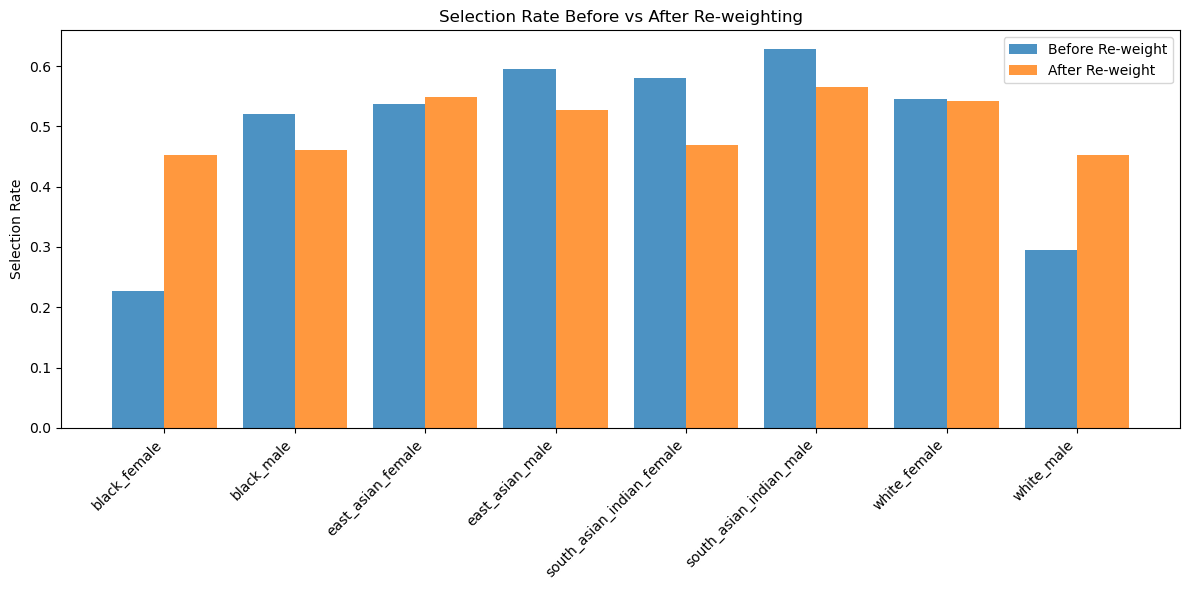

In [41]:
# ========================================
# 1. Plot Before/After Selection Rates
# ========================================
groups = list(ideal_human_feedback.keys())

before = [raw_rate[g] for g in groups]
after = [weighted_rate[g] for g in groups]

plt.figure(figsize=(12,6))
x = np.arange(len(groups))

plt.bar(x - 0.2, before, width=0.4, label="Before Re-weight", alpha=0.8)
plt.bar(x + 0.2, after, width=0.4, label="After Re-weight", alpha=0.8)

plt.xticks(x, groups, rotation=45, ha="right")
plt.ylabel("Selection Rate")
plt.title("Selection Rate Before vs After Re-weighting")
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
# ========================================
# 2. Compute DPR before & after reweight
# ========================================

def compute_dpr(rate_dict):
    vals = [v for v in rate_dict.values() if not np.isnan(v)]
    return max(vals) / min(vals)

raw_dpr = compute_dpr(raw_rate)
weighted_dpr = compute_dpr(weighted_rate)

print("Raw DPR =", raw_dpr)
print("Weighted DPR =", weighted_dpr)

Raw DPR = 2.7627906976744185
Weighted DPR = 1.2491391822944438


In [45]:
df_ab.to_csv("human_preferences_reweighted.csv", index=False, encoding="utf-8")
print("Saved: human_preferences_reweighted.csv")

Saved: human_preferences_reweighted.csv


In [47]:
from IPython.display import FileLink
FileLink("human_preferences_reweighted.csv")

/Users/cuicuiyue/human_preferences_reweighted.csv